## Download LFMC Map from Google Earth

In [ ]:
import ee
ee.Authenticate()

print(ee.Image("NASA/NASADEM_HGT/001").get("title").getInfo())

In [ ]:
import ee
from ee import batch
from pandas.tseries.offsets import DateOffset
import pandas as pd

## Initialize (a ee python thing)


ee.Initialize()

#%%
### Input start and end dates
start_date = '2016-04-01'
end_date =  '2021-04-25'
folder_name = 'lfmc_folder_manav' # folder name in GOogle drive where files should be created
scale = 250 #pixel size in meters. lower pixels will consumer more memory and will take longer to download. 

#%%#### create strings for start and end dates

collection = ee.ImageCollection('users/kkraoj/lfm-mapper/lfmc_col_25_may_2021').\
                filterDate(start_date,end_date)


crs = ee.Image(collection.first()).projection();
def resample(image):
    image = image.resample('bilinear').reproject(crs= crs,scale= scale)
    return image

if scale!=250: #if user requested resolution is different than native resolution (250m), resample to new resolution
    collection = collection.map(resample)
                
n = collection.size().getInfo() # number of images to download
    
colList = collection.toList(n)
  
for i in range(n):
    image = ee.Image(colList.get(i));
    id = image.id().getInfo() or 'image_'+i.toString();

    out = batch.Export.image.toDrive(
      image=image,
      folder=folder_name,
      description = id,
      scale= scale,
      maxPixels=1e11
    )
    batch.Task.start(out)    
## process the image

out.status()
print("process sent to cloud")

## PreProcessing The Maps

In [2]:

import geopandas as gpd
import glob
import os
from bisect import bisect_left, bisect_right
from os import listdir
from os.path import isfile, join
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
from rasterio.mask import mask
import rasterio
from fiona.crs import from_epsg
from shapely.geometry import box
from pyproj import Transformer
import pycrs
import numpy as np
import matplotlib.pyplot as plt
import random
from matplotlib import cm



In [3]:


def getFeatures(gdf):
    """Function to parse features from GeoDataFrame in such a manner that rasterio wants them"""
    import json
    return [json.loads(gdf.to_json())['features'][0]['geometry']]



In [4]:
points_fire = gpd.read_file(r'F:\Backup\backup_ML_project\ML_Project\fire-classification-main\data\GIS\points_fire_sample.shp')
points_nofire = gpd.read_file(r'F:\Backup\backup_ML_project\ML_Project\fire-classification-main\data\GIS\points_nofire_sample.shp')


In [5]:
path = r'F:\Backup\backup_ML_project\ML_Project\lfmc_250m\lfmc'

filenames = [f for f in listdir(path) if isfile(join(path, f)) and f.endswith('.tif')]

# get dates of map
dates = [f.split("map_")[1].split(".tif")[0] for f in filenames]
dates = [datetime.strptime(date_string, "%Y-%m-%d").date() for date_string in dates]
dates = sorted(dates)
points_fire['geometry']



0       POINT (-13333457.246 4526689.343)
1       POINT (-13363022.590 4526215.524)
2       POINT (-13337677.876 4526270.873)
3       POINT (-13365119.776 4528411.255)
4       POINT (-13335991.257 4528782.936)
                      ...                
1923    POINT (-13335627.271 4527901.373)
1924    POINT (-13383471.436 4526036.447)
1925    POINT (-13334629.597 4526564.277)
1926    POINT (-13378565.769 4525885.762)
1927    POINT (-13378565.769 4525885.762)
Name: geometry, Length: 1928, dtype: geometry

### Fire Maps

In [6]:
out_path = r"F:\Backup\backup_ML_project\ML_Project\Test_phase1_preprocessing\input_data\fire"

#for i in range(len(points_fire)):
i=0
# get fire date
fire_date = points_fire['IgntDate'].iloc[i]
fire_date = datetime.strptime(fire_date, "%Y-%m-%d").date()
#     print(fire_date)

# get closest map to fire date
nearest_date = dates[:bisect_left(dates, fire_date)][-1]
nearest_date = nearest_date.strftime('%Y-%m-%d')

# get file corresponding to nearest date
file = "lfmc_map_{}.tif".format(nearest_date)

# Input raster
fp = os.path.join(path, file)

# Read the data
data = rasterio.open(fp)

# Crop image to have coordinate in center
x_center = points_fire['geometry'].iloc[i].x
y_center = points_fire['geometry'].iloc[i].y

transformer = Transformer.from_crs("epsg:3857", "epsg:4326")
x_center, y_center = transformer.transform(x_center,y_center)

xmin = x_center - 16 * data.transform[4] # pixel size
xmax = x_center + 15 * data.transform[4]
ymin = y_center - 16 * (-data.transform[0])
ymax = y_center + 15 * (-data.transform[0])

# create bounding box
bbox = box(ymin, xmin, ymax, xmax)
geo = gpd.GeoDataFrame({'geometry': bbox}, index=[0], crs=from_epsg(4326))
geo = geo.to_crs(crs = data.crs.data)

coords = getFeatures(geo)

# Save cropped image
out_tif = os.path.join(out_path, 'fire_{}.tif'.format(i))
print(out_tif)

# Clip the raster with Polygon
out_img, out_transform = mask(dataset=data, shapes=coords, crop=True)

# copy the metadata
out_meta = data.meta.copy()
epsg_code = int(data.crs.data['init'][5:])
out_meta.update({"driver": "GTiff",
                 "height": out_img.shape[1],
                 "width": out_img.shape[2],
                 "transform": out_transform,
                 "crs": pycrs.parse.from_epsg_code(epsg_code).to_proj4()})

with rasterio.open(out_tif, "w", **out_meta) as dest:
    dest.write(out_img)


C:\Users\Manvendra Nema\anaconda3\envs\LFMC\Lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


F:\Backup\backup_ML_project\ML_Project\Test_phase1_preprocessing\input_data\fire\fire_0.tif


### No Fire Maps

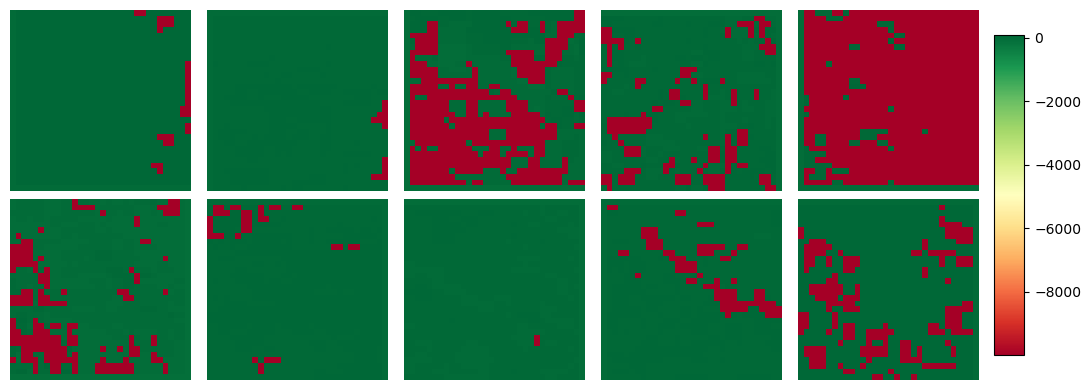

In [8]:

# Visualize some images
out_path = r"F:\Backup\backup_ML_project\ML_Project\Test_phase1_preprocessing\input_data\fire"
images = [f for f in listdir(out_path) if isfile(join(out_path, f)) and f.endswith('.tif')]

fig = plt.figure(figsize = (10,4))

for i in range(10):
    idx = random.randint(0, len(images))
    plt.subplot(2,5,i+1)
    src = rasterio.open(os.path.join(out_path, images[idx]))
    plt.imshow(src.read(1), cmap = cm.RdYlGn)
    plt.axis('off')

# plt.subplots_adjust(bottom=0.1, right=0.5, top=0.6)
fig.tight_layout()
cax = plt.axes([1.0, 0.1, 0.03, 0.8])
plt.colorbar(cax=cax)
plt.show()




In [9]:
out_path = r"F:\Backup\backup_ML_project\ML_Project\Test_phase1_preprocessing\input_data\nofire"

# for i in range(len(points_fire)):


# get fire date
idx = random.randint(0, len(points_fire)-1)
fire_date = points_fire['IgntDate'].iloc[idx]
fire_date = datetime.strptime(fire_date, "%Y-%m-%d").date()

# get range not within 1 year of fire (6 months before and 6 months after)
prev_6 = fire_date + relativedelta(months = -6)
next_6 = fire_date + relativedelta(months = +6)
date_range = dates[:bisect_left(dates, prev_6)]
date_range.extend(dates[bisect_right(dates, next_6):])

# get random date in date_range
rnd_ind = random.randint(0, len(date_range)-1)
chosen_date = date_range[rnd_ind].strftime('%Y-%m-%d')

# get file corresponding to nearest date
file = "lfmc_map_{}.tif".format(chosen_date)

# Input raster
fp = os.path.join(path, file)

# Read the data
data = rasterio.open(fp)

# Crop image to have coordinate in center
x_center = points_fire['geometry'].iloc[idx].x
y_center = points_fire['geometry'].iloc[idx].y

transformer = Transformer.from_crs("epsg:3857", "epsg:4326")
x_center, y_center = transformer.transform(x_center,y_center)

xmin = x_center - 16 * data.transform[4] # pixel size
xmax = x_center + 15 * data.transform[4]
ymin = y_center - 16 * (-data.transform[0])
ymax = y_center + 15 * (-data.transform[0])

# create bounding box
bbox = box(ymin, xmin, ymax, xmax)
geo = gpd.GeoDataFrame({'geometry': bbox}, index=[0], crs=from_epsg(4326))
geo = geo.to_crs(crs = data.crs.data)

coords = getFeatures(geo)

# Save cropped image
out_tif = os.path.join(out_path, 'nofire_{}.tif'.format(i))
print(out_tif)

# Clip the raster with Polygon
out_img, out_transform = mask(dataset=data, shapes=coords, crop=True)

# copy the metadata
out_meta = data.meta.copy()
epsg_code = int(data.crs.data['init'][5:])
out_meta.update({"driver": "GTiff",
                 "height": out_img.shape[1],
                 "width": out_img.shape[2],
                 "transform": out_transform,
                 "crs": pycrs.parse.from_epsg_code(epsg_code).to_proj4()})

with rasterio.open(out_tif, "w", **out_meta) as dest:
    dest.write(out_img)


C:\Users\Manvendra Nema\anaconda3\envs\LFMC\Lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


F:\Backup\backup_ML_project\ML_Project\Test_phase1_preprocessing\input_data\nofire\nofire_9.tif


In [10]:

# For non-fire points
out_path = r"F:\Backup\backup_ML_project\ML_Project\Test_phase1_preprocessing\input_data\nofire"

# for i in range(len(points_fire)):

    
    # get fire date
idx = random.randint(0, len(points_nofire)-1)
fire_date = points_fire['IgntDate'].iloc[idx]
fire_date = datetime.strptime(fire_date, "%Y-%m-%d").date()

# get range not within 1 year of fire (6 months before and 6 months after)
prev_6 = fire_date + relativedelta(months = -6)
next_6 = fire_date + relativedelta(months = +6)
date_range = dates[:bisect_left(dates, prev_6)]
date_range.extend(dates[bisect_right(dates, next_6):])

# get random date in date_range
rnd_ind = random.randint(0, len(date_range)-1)
chosen_date = date_range[rnd_ind].strftime('%Y-%m-%d')

# get file corresponding to nearest date
file = "lfmc_map_{}.tif".format(chosen_date)

# Input raster
fp = os.path.join(path, file)

# Read the data
data = rasterio.open(fp)

# Crop image to have coordinate in center
x_center = points_fire['geometry'].iloc[idx].x
y_center = points_fire['geometry'].iloc[idx].y

transformer = Transformer.from_crs("epsg:3857", "epsg:4326")
x_center, y_center = transformer.transform(x_center,y_center)

xmin = x_center - 16 * data.transform[4] # pixel size
xmax = x_center + 15 * data.transform[4]
ymin = y_center - 16 * (-data.transform[0])
ymax = y_center + 15 * (-data.transform[0])

# create bounding box
bbox = box(ymin, xmin, ymax, xmax)
geo = gpd.GeoDataFrame({'geometry': bbox}, index=[0], crs=from_epsg(4326))
geo = geo.to_crs(crs = data.crs.data)

coords = getFeatures(geo)

# Save cropped image
out_tif = os.path.join(out_path, 'nofire_{}.tif'.format(i))
print(out_tif)

# Clip the raster with Polygon
out_img, out_transform = mask(dataset=data, shapes=coords, crop=True)

# copy the metadata
out_meta = data.meta.copy()
epsg_code = int(data.crs.data['init'][5:])
out_meta.update({"driver": "GTiff",
                 "height": out_img.shape[1],
                 "width": out_img.shape[2],
                 "transform": out_transform,
                 "crs": pycrs.parse.from_epsg_code(epsg_code).to_proj4()})

with rasterio.open(out_tif, "w", **out_meta) as dest:
    dest.write(out_img)



C:\Users\Manvendra Nema\anaconda3\envs\LFMC\Lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


F:\Backup\backup_ML_project\ML_Project\Test_phase1_preprocessing\input_data\nofire\nofire_9.tif


## Visualize Maps

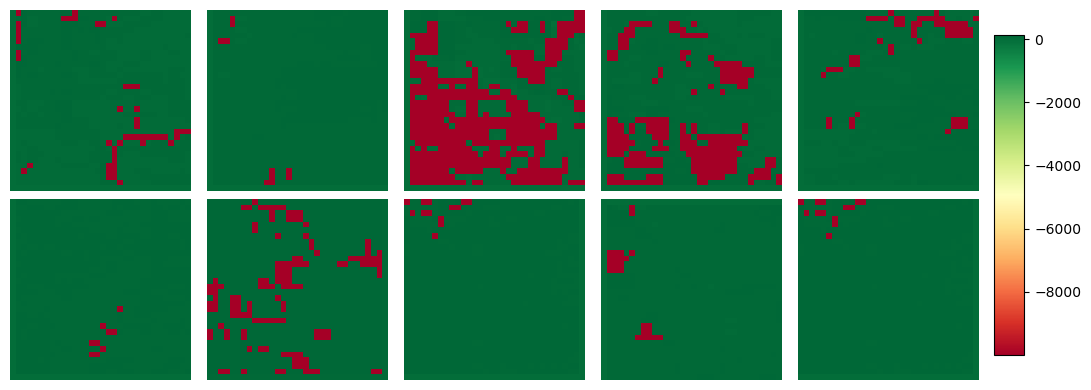

In [11]:


out_path = r"F:\Backup\backup_ML_project\ML_Project\Test_phase1_preprocessing\input_data\nofire"
images = [f for f in listdir(out_path) if isfile(join(out_path, f)) and f.endswith('.tif')]

fig = plt.figure(figsize = (10,4))

for i in range(10):
    idx = random.randint(0, len(images))
    plt.subplot(2,5,i+1)
    src = rasterio.open(os.path.join(out_path, images[idx]))
    plt.imshow(src.read(1), cmap = cm.RdYlGn)
    plt.axis('off')

fig.tight_layout()
cax = plt.axes([1.0, 0.1, 0.03, 0.8])
plt.colorbar(cax=cax)
plt.show()




In [14]:

import splitfolders
splitfolders.ratio(r"F:\Backup\backup_ML_project\ML_Project\Test_phase1_preprocessing\input_data", output=r"F:\Backup\backup_ML_project\ML_Project\Test_phase1_preprocessing\processed_data", seed=1337, ratio=(.8, .2), group_prefix=None) # default values



F:\Backup\backup_ML_project\ML_Project\fire-classification-main\data\processed_data\train\fire\fire_1.tif
F:\Backup\backup_ML_project\ML_Project\fire-classification-main\data\processed_data\train\fire\fire_10.tif
F:\Backup\backup_ML_project\ML_Project\fire-classification-main\data\processed_data\train\fire\fire_100.tif
F:\Backup\backup_ML_project\ML_Project\fire-classification-main\data\processed_data\train\fire\fire_1000.tif
F:\Backup\backup_ML_project\ML_Project\fire-classification-main\data\processed_data\train\fire\fire_1002.tif
F:\Backup\backup_ML_project\ML_Project\fire-classification-main\data\processed_data\train\fire\fire_1003.tif
F:\Backup\backup_ML_project\ML_Project\fire-classification-main\data\processed_data\train\fire\fire_1004.tif
F:\Backup\backup_ML_project\ML_Project\fire-classification-main\data\processed_data\train\fire\fire_1005.tif
F:\Backup\backup_ML_project\ML_Project\fire-classification-main\data\processed_data\train\fire\fire_1006.tif
F:\Backup\backup_ML_proje

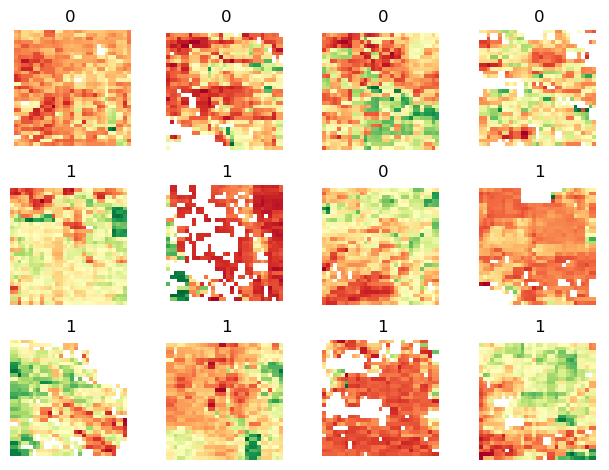

In [32]:
from glob import glob
import numpy as np
import rasterio as rio
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from matplotlib import cm

from sklearn import datasets, svm, metrics
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

from sklearn.model_selection import RandomizedSearchCV
import os
root = r"F:\Backup\backup_ML_project\ML_Project\fire-classification-main\data"

fire = glob(r'F:\Backup\backup_ML_project\ML_Project\fire-classification-main\data\processed_data\train\fire\*.tif')
X = []
y = []
for i in fire:
    print(i)
    with rio.open(i, 'r') as f:
        X.append(f.read(1))
    y.append(1)
print(len(y))


nofire = glob(r'F:\Backup\backup_ML_project\ML_Project\fire-classification-main\data\processed_data\train\nofire\*.tif')

for i in nofire:
    print(i)
    with rio.open(i, 'r') as f:
        X.append(f.read(1))
    y.append(0)
print(len(y))

fig = plt.figure()


idx = np.random.randint(0,len(X), 12)

j = 1
for i in idx:
    plt.subplot(3,4,j)
    masked_array = np.ma.masked_where(X[i] == 0, X[i])
    plt.imshow(masked_array, cmap = cm.RdYlGn)
    plt.title(y[i])
    plt.axis('off')
    j+=1
    
fig.tight_layout()
plt.show()



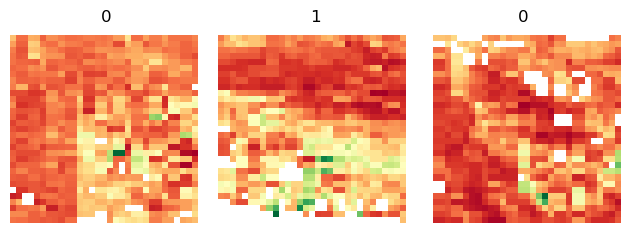

In [33]:
fig = plt.figure()

idx = np.random.randint(0,len(X), 3)

j = 1
for i in idx:
    plt.subplot(1,3,j)
    masked_array = np.ma.masked_where(X[i] == 0, X[i])
    plt.imshow(masked_array, cmap = cm.RdYlGn)
    plt.title(y[i])
    plt.axis('off')
    j+=1

fig.tight_layout()
plt.show()



In [34]:
# stack data
X = np.stack(X)
y = np.array(y)


In [35]:

n_samples = X.shape[0]
X_data = X.reshape((n_samples, -1))


## Model Creation

In [36]:

# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X_data,y, test_size = 0.2, random_state = 42)
print('Training data and target sizes: \n{}, {}'.format(X_train.shape,y_train.shape))
print('Test data and target sizes: \n{}, {}'.format(X_test.shape,y_test.shape))


Training data and target sizes: 
(2257, 1024), (2257,)
Test data and target sizes: 
(565, 1024), (565,)


### KNN

The optimal number of neighbors is 7


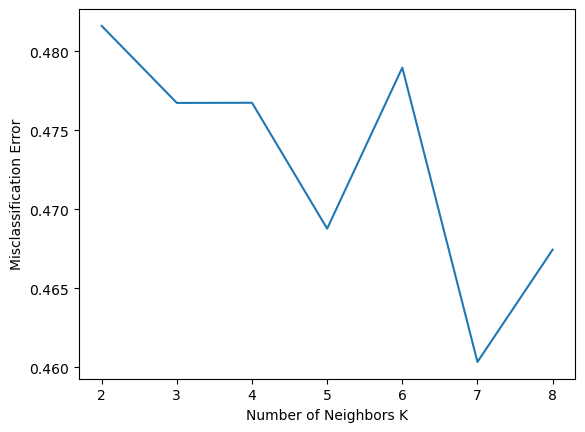

In [37]:

# Cross Validation to check best k
X_train, X_test, y_train, y_test = train_test_split(X_data,y, test_size = 0.2, random_state = 42)

neighbors = list(range(2,9,1))
cv_scores = []

for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors = k)
    scores = cross_val_score(knn, X_train, y_train, cv = 5, scoring = 'accuracy')
    cv_scores.append(scores.mean())

# Plot misclassification error
mse = [1 - x for x in cv_scores]

# determine the best k
optimal_k = neighbors[mse.index(min(mse))]
print("The optimal number of neighbors is {}".format(str(optimal_k)))

# plot misclassification error vs k
plt.figure()
plt.plot(neighbors, mse)
plt.xlabel("Number of Neighbors K")
plt.ylabel("Misclassification Error")
plt.show()



In [38]:
# Using the optimal_k predict the test test
KNN_model = KNeighborsClassifier(n_neighbors = optimal_k)
KNN_model.fit(X_train, y_train)

# Predict on the test set
KNN_result = metrics.accuracy_score(KNN_model.predict(X_test), y_test)
train_result = metrics.accuracy_score(KNN_model.predict(X_train), y_train)
print("The Accuracy is {} \n".format(str(KNN_result)))

The Accuracy is 0.5415929203539823 



### SVC & RandomForest

In [42]:
from sklearn.metrics import accuracy_score, classification_report
from sklearn.svm import SVC

# SVM classifier
svm_model = SVC(kernel='rbf')  # You can specify different kernels like 'rbf', 'poly', etc.
svm_model.fit(X_train, y_train)
svm_predictions = svm_model.predict(X_test)

rf_model = RandomForestClassifier(n_estimators=100)  # You can adjust the number of trees (n_estimators) as needed
rf_model.fit(X_train, y_train)
rf_predictions = rf_model.predict(X_test)

# Evaluate SVM classifier
svm_accuracy = accuracy_score(y_test, svm_predictions)
svm_report = classification_report(y_test, svm_predictions)

# Evaluate Random Forest classifier
rf_accuracy = accuracy_score(y_test, rf_predictions)
rf_report = classification_report(y_test, rf_predictions)

# Print results
print("SVM Accuracy:", svm_accuracy)
print("SVM Report:")
print(svm_report)

print("\nRandom Forest Accuracy:", rf_accuracy)
print("Random Forest Report:")
print(rf_report)

SVM Accuracy: 0.6336283185840708
SVM Report:
              precision    recall  f1-score   support

           0       0.63      0.49      0.55       258
           1       0.64      0.75      0.69       307

    accuracy                           0.63       565
   macro avg       0.63      0.62      0.62       565
weighted avg       0.63      0.63      0.63       565


Random Forest Accuracy: 0.7132743362831858
Random Forest Report:
              precision    recall  f1-score   support

           0       0.71      0.63      0.67       258
           1       0.72      0.79      0.75       307

    accuracy                           0.71       565
   macro avg       0.71      0.71      0.71       565
weighted avg       0.71      0.71      0.71       565

